# DiffEqBiological Tutorial II: Network Properties API
### Samuel Isaacson

The [DiffEqBiological
API](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html) provides a
collection of functions for easily accessing network properties, and for
incrementally building and extending a network. In this tutorial we'll go
through the API, and then illustrate how to programmatically construct a
network.

We'll illustrate the API using a toggle-switch like network that contains a
variety of different reaction types:

In [36]:
using DifferentialEquations, DiffEqBiological, Latexify, Plots
fmt = :svg
pyplot(fmt=fmt)
rn = @reaction_network begin
    hillr(D₂,α,K,n), ∅ --> m₁
    hillr(D₁,α,K,n), ∅ --> m₂
    (δ,γ), m₁ ↔ ∅
    (δ,γ), m₂ ↔ ∅
    β, m₁ --> m₁ + P₁
    β, m₂ --> m₂ + P₂
    μ, P₁ --> ∅
    μ, P₂ --> ∅
    (k₊,k₋), 2P₁ ↔ D₁ 
    (k₊,k₋), 2P₂ ↔ D₂
    (k₊,k₋), P₁+P₂ ↔ T
end α K n δ γ β μ k₊ k₋;

This corresponds to the chemical reaction network given by

In [2]:
latexify(rn; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + D_2^{n}}] m_{1}}\\
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + D_1^{n}}] m_{2}}\\
\ce{ m_{1} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{2} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{1} &->[\beta] m_{1} + P_{1}}\\
\ce{ m_{2} &->[\beta] m_{2} + P_{2}}\\
\ce{ P_{1} &->[\mu] \varnothing}\\
\ce{ P_{2} &->[\mu] \varnothing}\\
\ce{ 2 \cdot P_1 &<=>[k_{+}][k_{-}] D_{1}}\\
\ce{ 2 \cdot P_2 &<=>[k_{+}][k_{-}] D_{2}}\\
\ce{ P_{1} + P_{2} &<=>[k_{+}][k_{-}] T}
\end{align}
"

---
## Network Properties
[Basic
properties](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Basic-properties-1)
of the generated network include the `speciesmap` and `paramsmap` functions we
examined in the last tutorial, along with the corresponding `species` and
`params` functions:

In [3]:
species(rn)

7-element Array{Symbol,1}:
 :m₁
 :m₂
 :P₁
 :P₂
 :D₁
 :D₂
 :T 

In [4]:
params(rn)

9-element Array{Symbol,1}:
 :α 
 :K 
 :n 
 :δ 
 :γ 
 :β 
 :μ 
 :k₊
 :k₋

The numbers of species, parameters and reactions can be accessed using
`numspecies(rn)`, `numparams(rn)` and `numreactions(rn)`.

A number of functions are available to access [properties of
reactions](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Reaction-Properties-1)
within the generated network, including `substrates`, `products`, `dependents`,
`ismassaction`, `substratestoich`, `substratesymstoich`, `productstoich`,
`productsymstoich`, and `netstoich`. Each of these functions takes two
arguments, the reaction network `rn` and the index of the reaction to query
information about. For example, to find the substrate symbols and their
corresponding stoichiometries for the 11th reaction, `2P₁ --> D₁`, we would use

In [5]:
substratesymstoich(rn, 11)

1-element Array{DiffEqBiological.ReactantStruct,1}:
 DiffEqBiological.ReactantStruct(:P₁, 2)

Broadcasting works on all these functions, allowing the construction of a vector
holding the queried information across all reactions, i.e.

In [6]:
substratesymstoich.(rn, 1:numreactions(rn))

16-element Array{Array{DiffEqBiological.ReactantStruct,1},1}:
 []                                              
 []                                              
 [ReactantStruct(:m₁, 1)]                        
 []                                              
 [ReactantStruct(:m₂, 1)]                        
 []                                              
 [ReactantStruct(:m₁, 1)]                        
 [ReactantStruct(:m₂, 1)]                        
 [ReactantStruct(:P₁, 1)]                        
 [ReactantStruct(:P₂, 1)]                        
 [ReactantStruct(:P₁, 2)]                        
 [ReactantStruct(:D₁, 1)]                        
 [ReactantStruct(:P₂, 2)]                        
 [ReactantStruct(:D₂, 1)]                        
 [ReactantStruct(:P₁, 1), ReactantStruct(:P₂, 1)]
 [ReactantStruct(:T, 1)]                         

To see the net stoichiometries for all reactions we would use

In [7]:
netstoich.(rn, 1:numreactions(rn))

16-element Array{Array{Pair{Int64,Int64},1},1}:
 [1=>1]              
 [2=>1]              
 [1=>-1]             
 [1=>1]              
 [2=>-1]             
 [2=>1]              
 [3=>1]              
 [4=>1]              
 [3=>-1]             
 [4=>-1]             
 [3=>-2, 5=>1]       
 [3=>2, 5=>-1]       
 [4=>-2, 6=>1]       
 [4=>2, 6=>-1]       
 [3=>-1, 4=>-1, 7=>1]
 [3=>1, 4=>1, 7=>-1] 

Here the first integer in each pair corresponds to the index of the species
(with symbol `species(rn)[index]`). The second integer corresponds to the net
stoichiometric coefficient of the species within the reaction. `substratestoich`
and `productstoich` are defined similarly. 

Several functions are also provided that calculate different types of
[dependency
graphs](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Dependency-Graphs-1).
These include `rxtospecies_depgraph`, which provides a mapping from reaction
index to the indices of species whose population changes when the reaction
occurs:

In [8]:
rxtospecies_depgraph(rn)

16-element Array{Array{Int64,1},1}:
 [1]      
 [2]      
 [1]      
 [1]      
 [2]      
 [2]      
 [3]      
 [4]      
 [3]      
 [4]      
 [3, 5]   
 [3, 5]   
 [4, 6]   
 [4, 6]   
 [3, 4, 7]
 [3, 4, 7]

Here the last row indicates that the species with indices `[3,4,7]` will change
values when the reaction `T --> P₁ + P₂` occurs. To confirm these are the
correct species we can look at

In [9]:
species(rn)[[3,4,7]]

3-element Array{Symbol,1}:
 :P₁
 :P₂
 :T 

The `speciestorx_depgraph` similarly provides a mapping from species to reactions 
for which their *rate laws* depend on that species. These correspond to all reactions
for which the given species is in the `dependent` set of the reaction. We can verify this
for the first species, `m₁`:

In [10]:
speciestorx_depgraph(rn)[1]

2-element Array{Int64,1}:
 3
 7

In [11]:
findall(depset -> in(:m₁, depset), dependents.(rn, 1:numreactions(rn)))

2-element Array{Int64,1}:
 3
 7

Finally, `rxtorx_depgraph` provides a mapping that shows when a given reaction
occurs, which other reactions have rate laws that involve species whose value
would have changed:

In [12]:
rxtorx_depgraph(rn)

16-element Array{Array{Int64,1},1}:
 [1, 3, 7]              
 [2, 5, 8]              
 [3, 7]                 
 [3, 4, 7]              
 [5, 8]                 
 [5, 6, 8]              
 [7, 9, 11, 15]         
 [8, 10, 13, 15]        
 [9, 11, 15]            
 [10, 13, 15]           
 [2, 9, 11, 12, 15]     
 [2, 9, 11, 12, 15]     
 [1, 10, 13, 14, 15]    
 [1, 10, 13, 14, 15]    
 [9, 10, 11, 13, 15, 16]
 [9, 10, 11, 13, 15, 16]

#### Note on Using Network Property API Functions
Many basic network query and reaction property functions are simply accessors,
returning information that is already stored within the generated
`reaction_network`. For these functions, modifying the returned data structures
may lead to inconsistent internal state within the network. As such, they should
be used for accessing, but not modifying, network properties. The [API
documentation](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html)
indicates which functions return newly allocated data structures and which
return data stored within the `reaction_network`.

---
## Incremental Construction of Networks
The `@reaction_network` macro is monolithic, in that it not only constructs and
stores basic network properties such as the reaction stoichiometries, but also
generates **everything** needed to immediately solve ODE, SDE and jump models
using the network. This includes Jacobian functions, noise functions, and jump
functions for each reaction. While this allows for a compact interface to the
DifferentialEquations.jl solvers, it can also be computationally expensive for
large networks, where a user may only wish to solve one type of problem and/or
have fine-grained control over what is generated. In addition, some types of
reaction network structures are more amenable to being constructed
programmatically, as opposed to writing out all reactions by hand within one
macro. For these reasons DiffEqBiological provides two additional macros that
only *initially* setup basic reaction network properties, and which can be
extended through a programmatic interface: `@min_reaction_network` and
`@empty_reaction_network`. We now give an introduction to constructing these
more minimal network representations, and how they can be programmatically
extended. See also the relevant [API
section](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Reaction-Network-Generation-Macros-1).

The `@min_reaction_network` macro works identically to the `@reaction_network`
macro, but the generated network will only be complete with respect to its
representation of chemical network properties (i.e. species, parameters and
reactions). No ODE, SDE or jump models are generated during the macro call. It
can subsequently be extended with the addition of new species, parameters or
reactions. The `@empty_reaction_network` allocates an empty network structure
that can also be extended using the programmatic interface. For example, consider
a partial version of the toggle-switch like network we defined above:

In [13]:
rnmin = @min_reaction_network begin
    (δ,γ), m₁ ↔ ∅
    (δ,γ), m₂ ↔ ∅
    β, m₁ --> m₁ + P₁
    β, m₂ --> m₂ + P₂
    μ, P₁ --> ∅
    μ, P₂ --> ∅
end δ γ β μ;

Here we have left out the first two, and last three, reactions from the original
`reaction_network`. To expand the network until it is functionally equivalent to
the original model we add back in the missing species, parameters, and *finally*
the missing reactions. Note, it is required that species and parameters be
defined before any reactions using them are added. The necessary network
extension functions are given by `addspecies!`, `addparam!` and `addreaction!`,
and described in the
[API](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Functions-to-Add-Species,-Parameters-and-Reactions-to-a-Network-1). To complete `rnmin` we first add the relevant
species:

In [14]:
addspecies!(rnmin, :D₁)
addspecies!(rnmin, :D₂)
addspecies!(rnmin, :T)

Next we add the needed parameters

In [15]:
addparam!(rnmin, :α)
addparam!(rnmin, :K)
addparam!(rnmin, :n)
addparam!(rnmin, :k₊)
addparam!(rnmin, :k₋)

Note, both `addspecies!` and `addparam!` also accept strings encoding the
variable names (which are then converted to `Symbol`s internally).

We are now ready to add the missing reactions. The API provides two forms of the
`addreaction!` function, one takes expressions analogous to what one would write
in the macro:

In [16]:
addreaction!(rnmin, :(hillr(D₁,α,K,n)), :(∅ --> m₂))
addreaction!(rnmin, :((k₊,k₋)), :(2P₂ ↔ D₂))
addreaction!(rnmin, :k₊, :(2P₁ --> D₁))
addreaction!(rnmin, :k₋, :(D₁ --> 2P₁))

The rate can be an expression or symbol as above, but can also just be a
numeric value. The second form of `addreaction!` takes tuples of
`Pair{Symbol,Int}` that encode the stoichiometric coefficients of substrates and
reactants:

In [17]:
# signature is addreaction!(rnmin, paramexpr, substratestoich, productstoich)
addreaction!(rnmin, :(hillr(D₂,α,K,n)), (), (:m₁ => 1,))
addreaction!(rnmin, :k₊, (:P₁=>1, :P₂=>1), (:T=>1,))
addreaction!(rnmin, :k₋, (:T=>1,), (:P₁=>1, :P₂=>1))

Let's check that `rn` and `rnmin` have the same set of species:

In [18]:
setdiff(species(rn), species(rnmin))

0-element Array{Symbol,1}

the same set of params:

In [19]:
setdiff(params(rn), params(rnmin))

0-element Array{Symbol,1}

and the final reaction has the same substrates, reactions, and rate expression:

In [20]:
rxidx = numreactions(rn)
setdiff(substrates(rn, rxidx), substrates(rnmin, rxidx))

0-element Array{Symbol,1}

In [21]:
setdiff(products(rn, rxidx), products(rnmin, rxidx))

0-element Array{Symbol,1}

In [22]:
rateexpr(rn, rxidx) == rateexpr(rnmin, rxidx)

true

---
## Extending Incrementally Generated Networks to Include ODEs, SDEs or Jumps
Once a network generated from `@min_reaction_network` or
`@empty_reaction_network` has had all the associated species, parameters and
reactions filled in, corresponding ODE, SDE or jump models can be constructed.
The relevant API functions are `addodes!`, `addsdes!` and `addjumps!`. One
benefit to contructing models with these functions is that they offer more
fine-grained control over what actually gets constructed. For example,
`addodes!` has the optional keyword argument, `build_jac`, which if set to
`false` will disable construction of symbolic Jacobians and functions for
evaluating Jacobians. For large networks this can give a significant speed-up in
the time required for constructing an ODE model. Each function and its
associated keyword arguments are described in the API section, [Functions to add
ODEs, SDEs or Jumps to a
Network](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Functions-to-Add-ODEs,-SDEs-or-Jumps-to-a-Network-1).

Let's extend `rnmin` to include the needed functions for use in ODE
solvers:

In [23]:
addodes!(rnmin)

The [Generated Functions for
Models](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Generated-Functions-for-Models-1)
section of the API shows what functions have been generated. For ODEs these
include `oderhsfun(rnmin)`, which returns a function of the form `f(du,u,p,t)`
which evaluates the ODEs (i.e. the time derivatives of `u`) within `du`. For
each generated function, the corresponding expressions from which it was
generated can be retrieved using accessors from the [Generated
Expressions](http://docs.juliadiffeq.org/latest/apis/diffeqbio.html#Generated-Expressions-1)
section of the API. The equations within `du` can be retrieved using the
`odeexprs(rnmin)` function. For example:

In [24]:
odeexprs(rnmin)

7-element Array{Union{Float64, Int64, Expr, Symbol},1}:
 :((-(δ * m₁) + γ) + (α * K ^ n) / (K ^ n + D₂ ^ n))                                      
 :((-(δ * m₂) + γ) + (α * K ^ n) / (K ^ n + D₁ ^ n))                                      
 :(((((β * m₁ - μ * P₁) + -2 * k₊ * (P₁ ^ 2 / 2)) + 2 * k₋ * D₁) - k₊ * P₁ * P₂) + k₋ * T)
 :(((((β * m₂ - μ * P₂) + -2 * k₊ * (P₂ ^ 2 / 2)) + 2 * k₋ * D₂) - k₊ * P₁ * P₂) + k₋ * T)
 :(k₊ * (P₁ ^ 2 / 2) - k₋ * D₁)                                                           
 :(k₊ * (P₂ ^ 2 / 2) - k₋ * D₂)                                                           
 :(k₊ * P₁ * P₂ - k₋ * T)                                                                 

Using Latexify we can see the ODEs themselves to compare with these expressions:

In [25]:
latexify(rnmin)

L"\begin{align}
\frac{dm_1}{dt} =&  - \delta \cdot m_1 + \gamma + \frac{\alpha \cdot K^{n}}{K^{n} + D_2^{n}} \\
\frac{dm_2}{dt} =&  - \delta \cdot m_2 + \gamma + \frac{\alpha \cdot K^{n}}{K^{n} + D_1^{n}} \\
\frac{dP_1}{dt} =& \beta \cdot m_1 - \mu \cdot P_1 -2 \cdot k_+ \cdot \frac{P_1^{2}}{2} + 2 \cdot k_- \cdot D_1 - k_+ \cdot P_1 \cdot P_2 + k_- \cdot T \\
\frac{dP_2}{dt} =& \beta \cdot m_2 - \mu \cdot P_2 -2 \cdot k_+ \cdot \frac{P_2^{2}}{2} + 2 \cdot k_- \cdot D_2 - k_+ \cdot P_1 \cdot P_2 + k_- \cdot T \\
\frac{dD_1}{dt} =& k_+ \cdot \frac{P_1^{2}}{2} - k_- \cdot D_1 \\
\frac{dD_2}{dt} =& k_+ \cdot \frac{P_2^{2}}{2} - k_- \cdot D_2 \\
\frac{dT}{dt} =& k_+ \cdot P_1 \cdot P_2 - k_- \cdot T \\
\end{align}
"

For ODEs two other functions are generated by `addodes!`. `jacfun(rnmin)` will
return the generated Jacobian evaluation function, `fjac(dJ,u,p,t)`, which given
the current solution `u` evaluates the Jacobian within `dJ`.
`jacobianexprs(rnmin)` gives the corresponding matrix of expressions, which can
be used with Latexify to see the Jacobian:

In [26]:
latexify(jacobianexprs(rnmin))

L"\begin{equation}
\left[
\begin{array}{ccccccc}
 - \delta & 0 & 0 & 0 & 0 & \frac{ - K^{n} \cdot n \cdot \alpha \cdot D_2^{-1 + n}}{\left( K^{n} + D_2^{n} \right)^{2}} & 0 \\
0 &  - \delta & 0 & 0 & \frac{ - K^{n} \cdot n \cdot \alpha \cdot D_1^{-1 + n}}{\left( K^{n} + D_1^{n} \right)^{2}} & 0 & 0 \\
\beta & 0 &  - \mu - 2 \cdot k_+ \cdot P_1 - k_+ \cdot P_2 &  - k_+ \cdot P_1 & 2 \cdot k_- & 0 & k_{-} \\
0 & \beta &  - k_+ \cdot P_2 &  - \mu - k_+ \cdot P_1 - 2 \cdot k_+ \cdot P_2 & 0 & 2 \cdot k_- & k_{-} \\
0 & 0 & k_+ \cdot P_1 & 0 &  - k_- & 0 & 0 \\
0 & 0 & 0 & k_+ \cdot P_2 & 0 &  - k_- & 0 \\
0 & 0 & k_+ \cdot P_2 & k_+ \cdot P_1 & 0 & 0 &  - k_- \\
\end{array}
\right]
\end{equation}
"

`addodes!` also generates a function that evaluates the Jacobian of the ODE
derivative functions with respect to the parameters. `paramjacfun(rnmin)` then
returns the generated function. It has the form `fpjac(dPJ,u,p,t)`, which
given the current solution `u` evaluates the Jacobian matrix with respect to
parameters `p` within `dPJ`. For use in DifferentialEquations.jl solvers, an
[`ODEFunction`](http://docs.juliadiffeq.org/latest/features/performance_overloads.html)
representation of the ODEs is available from `odefun(rnmin)`. 

`addsdes!` and `addjumps!` work similarly to complete the network for use in
StochasticDiffEq and DiffEqJump solvers.  

#### Note on Using Generated Function and Expression API Functions
The generated functions and expressions accessible through the API require first
calling the appropriate `addodes!`, `addsdes` or `addjumps` function. These are
responsible for actually constructing the underlying functions and expressions.
The API accessors simply return already constructed functions and expressions
that are stored within the `reaction_network` structure.

---
## Example of Generating a Network Programmatically
For a user directly typing in a reaction network, it is generally easier to use
the `@min_reaction_network` or `@reaction_network` macros to fully specify
reactions. However, for large, structured networks it can be much easier to
generate the network programmatically. For very large networks, with tens of
thousands of reactions, the form of `addreaction!` that uses stoichiometric
coefficients should be preferred as it offers substantially better performance.
To put together everything we've seen, let's generate the network corresponding
to a 1D continuous time random walk, approximating the diffusion of molecules
within an interval.

The basic "reaction" network we wish to study is 

$$
u_1 \leftrightarrows u_2 \leftrightarrows u_3 \cdots \leftrightarrows u_{N}
$$

for $N$ lattice sites on $[0,1]$. For $h = 1/N$ the lattice spacing, we'll
assume the rate molecules hop from their current site to any particular neighbor
is just $h^{-2}$. We can interpret this hopping process as a collection of
$2N-2$ "reactions", with the form $u_i \to u_j$ for $j=i+1$ or $j=i-1$. We construct
the corresponding reaction network as follows. First we set values for the basic
parameters:

In [27]:
N = 64
h = 1 / N

0.015625

then we create an empty network, and add each species

In [28]:
rn = @empty_reaction_network

for i = 1:N
    addspecies!(rn, Symbol(:u, i))
end

We next add one parameter `β`, which we will set equal to the hopping rate 
of molecules, $h^{-2}$:

In [29]:
addparam!(rn, :β)

Finally, we add in the $2N-2$ possible hopping reactions:

In [30]:
for i = 1:N
    (i < N) && addreaction!(rn, :β, (Symbol(:u,i)=>1,), (Symbol(:u,i+1)=>1,))
    (i > 1) && addreaction!(rn, :β, (Symbol(:u,i)=>1,), (Symbol(:u,i-1)=>1,))
end

Let's first construct an ODE model for the network

In [31]:
addodes!(rn)

We now need to specify the initial condition, parameter vector and time interval
to solve on. We start with 10000 molecules placed at the center of the domain,
and setup an `ODEProblem` to solve:

In [32]:
u₀ = zeros(N)
u₀[div(N,2)] = 10000
p = [1/(h*h)]
tspan = (0.,.01)
oprob = ODEProblem(rn, u₀, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 0.01)
u0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

We are now ready to solve the problem and plot the solution. Since we have
essentially generated a method of lines discretization of the diffusion equation
with a discontinuous initial condition, we'll use an A-L stable implicit ODE
solver, `KenCarp4`, and plot the solution at a few times:

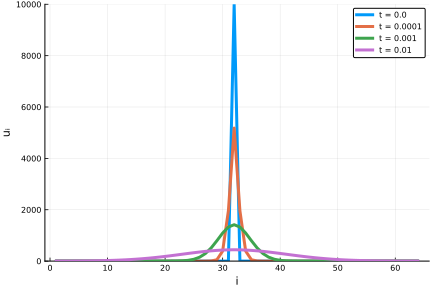

In [33]:
sol = solve(oprob, KenCarp4())
times = [0., .0001, .001, .01]
plt = plot()
for time in times
    plot!(plt, 1:N, sol(time), fmt=fmt, xlabel="i", ylabel="uᵢ", label=string("t = ", time), lw=3)
end
plot(plt, ylims=(0.,10000.))

Here we see the characteristic diffusion of molecules from the center of the
domain, resulting in a shortening and widening of the solution as $t$ increases.

Let's now look at a stochastic chemical kinetics jump process version of the
model, where β gives the probability per time each molecule can hop from its
current lattice site to an individual neighboring site. We first add in the
jumps, disabling `regular_jumps` since they are not needed, and using the
`minimal_jumps` flag to construct a minimal representation of the needed jumps.
We then construct a `JumpProblem`, and use the Composition-Rejection Direct
method, `DirectCR`, to simulate the process of the molecules hopping about on
the lattice:

In [34]:
addjumps!(rn, build_regular_jumps=false, minimal_jumps=true)

# make the initial condition integer valued 
u₀ = zeros(Int, N)
u₀[div(N,2)] = 10000

# setup and solve the problem
dprob = DiscreteProblem(rn, u₀, tspan, p)
jprob = JumpProblem(dprob, DirectCR(), rn, save_positions=(false,false))
jsol = solve(jprob, SSAStepper(), saveat=times)

retcode: Default
Interpolation: Piecewise constant interpolation
t: 4-element Array{Float64,1}:
 0.0   
 0.0001
 0.001 
 0.01  
u: 4-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]       
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]       
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]       
 [3, 2, 2, 6, 8, 5, 12, 9, 13, 21  …  14, 16, 10, 11, 3, 3, 0, 2, 0, 3]

We can now plot bar graphs showing the locations of the molecules at the same
set of times we examined the ODE solution. For comparison, we also plot the
corresponding ODE solutions (red lines) that we found:

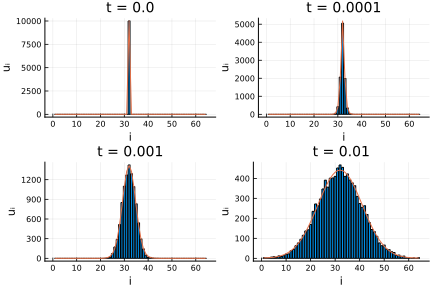

In [35]:
times = [0., .0001, .001, .01]
plts = []
for i = 1:4
    b = bar(1:N, jsol[i], legend=false, fmt=fmt, xlabel="i", ylabel="uᵢ", title=string("t = ", times[i]))
    plot!(b,sol(times[i]))
    push!(plts,b)
end
plot(plts...)

Similar to the ODE solutions, we see that the molecules spread out and become
more and more well-mixed throughout the domain as $t$ increases. The simulation
results are noisy due to the finite numbers of molecules present in the
stochsatic simulation, but since the number of molecules is large they agree
well with the ODE solution at each time.

---
## Getting Help
Have a question related to DiffEqBiological or this tutorial? Feel free to ask
in the DifferentialEquations.jl [Gitter](https://gitter.im/JuliaDiffEq/Lobby).
If you think you've found a bug in DiffEqBiological, or would like to
request/discuss new functionality, feel free to open an issue on
[Github](https://github.com/JuliaDiffEq/DiffEqBiological.jl) (but please check
there is no related issue already open). If you've found a bug in this tutorial,
or have a suggestion, feel free to open an issue on the [DiffEqTutorials Github
site](https://github.com/JuliaDiffEq/DiffEqTutorials.jl). Or, submit a pull
request to DiffEqTutorials updating the tutorial!

---